# What is Spark UI?

The Spark UI is a web-based interface that provides insights into the performance and behavior of Spark applications. It is useful for developers, data scientists, and other stakeholders who need to monitor and optimize their Spark applications. It is by default hosted at port 4040.

Here are the main components of the Spark UI:

1. Jobs: The Jobs tab displays information about the individual jobs in the application, including their status, duration, and resource usage.

2. Stages: The Stages tab provides a breakdown of each job into its individual stages, showing their status, duration, and resource usage.

3. Storage: The Storage tab shows the status of the Spark RDD (Resilient Distributed Datasets) storage, including the size of the RDD and the amount of memory used for caching.

4. Environment: The Environment tab shows the configuration and environment variables used in the Spark application.

5. Executors: The Executors tab displays information about the executors used in the application, including their resource usage and task execution times.

6. SQL/Dataframe: The SQL tab displays information about Spark SQL queries executed by the application, including their duration and resource usage.



These components are designed to provide a comprehensive view of the Spark application's performance, resource usage, and overall behavior, helping developers to optimize their applications and improve their performance.







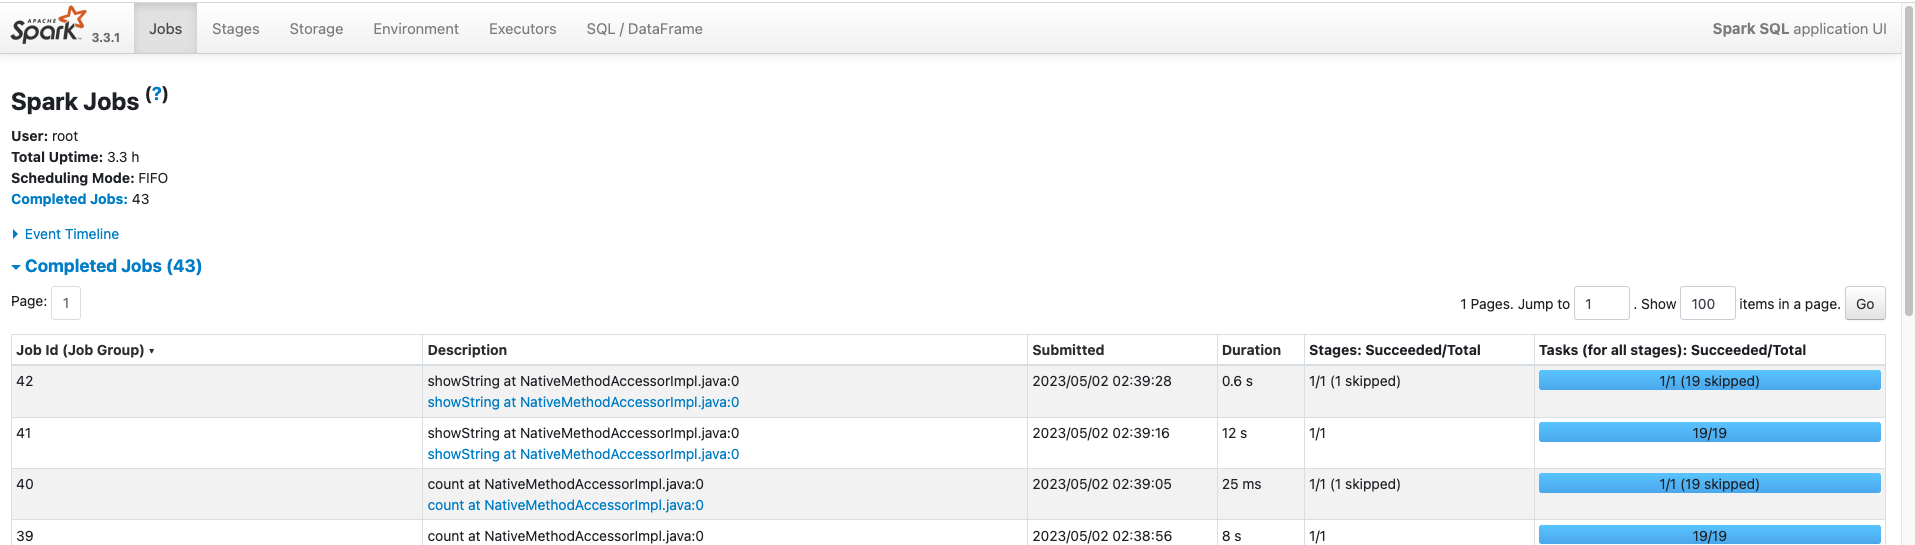

### Start Spark Session

In [1]:
import warnings
!sed -i 's/hadoop.root.logger=INFO,console/hadoop.root.logger=WARN,console/' /usr/hadoop-3.3.2/etc/hadoop/log4j.properties

In [2]:
!hadoop fs -copyFromLocal courses.csv  /courses.csv
!hadoop fs -copyFromLocal professors.csv  /professors.csv

2023-05-20 16:27:01,420 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-05-20 16:27:03,363 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import pyspark
from pyspark.sql import SparkSession

conf = pyspark.SparkConf().setAll([('spark.master', 'local[2]'),
                                   ('spark.app.name', 'Spark SQL')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

2023-05-20 16:27:08,594 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
!echo $SPARK_HOME

/usr/spark-3.3.1


### Load the required dataframes from HDFS

In [5]:
courses = spark.read.format("csv").option("header","true").load('hdfs:///courses.csv').cache()  ##Job id 0
professors = spark.read.format("csv").option("header","true").load('hdfs:///professors.csv').cache() ##Job id 1

In [6]:
print(courses.rdd.getNumPartitions())
print(professors.rdd.getNumPartitions())

1
1


### Environment Tab - The Environment tab shows the configuration and environment variables used in the Spark application.

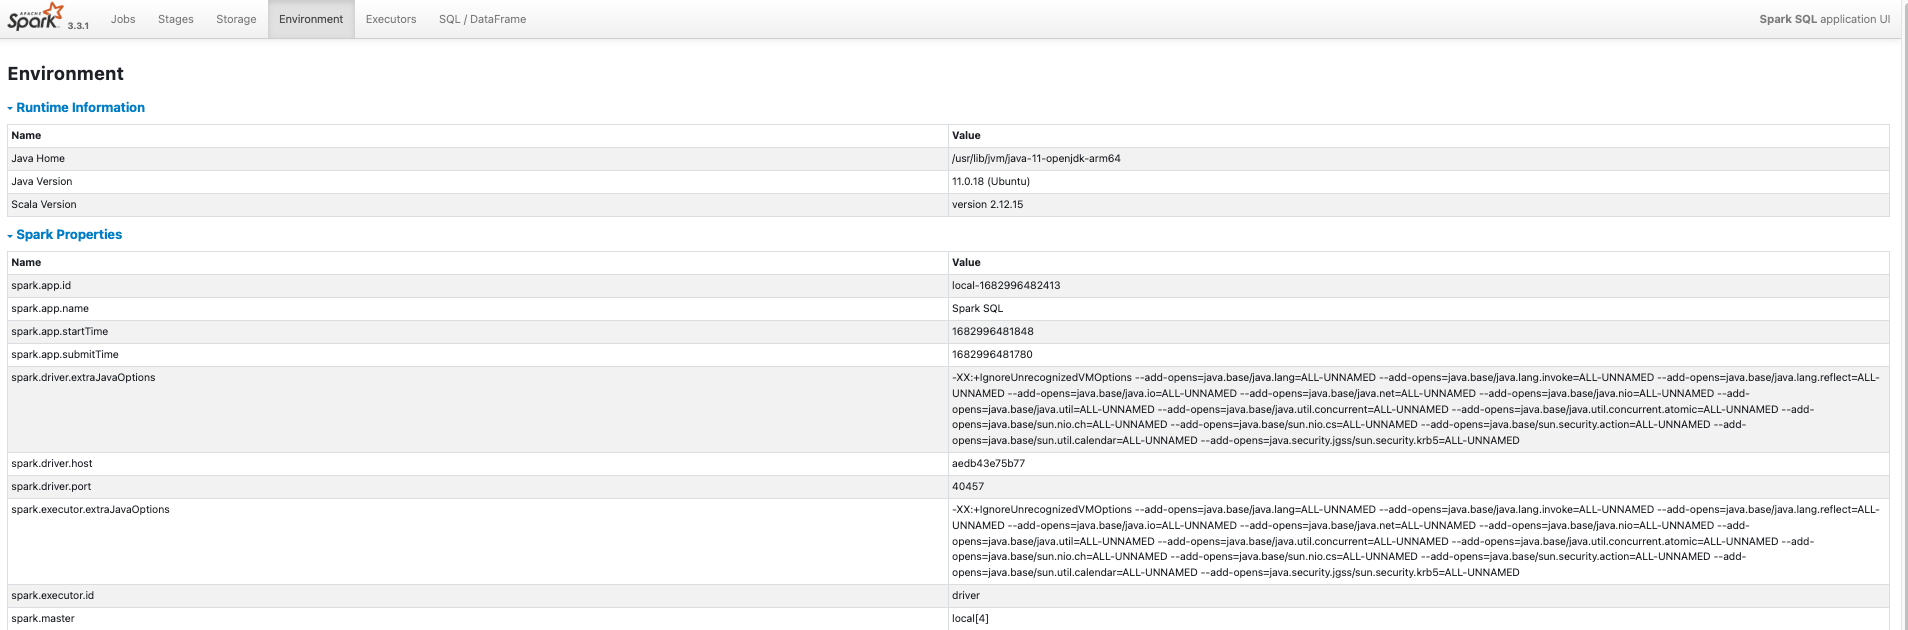

### Storage Tab-The Storage tab shows the status of the Spark RDD (Resilient Distributed Datasets) storage, including the size of the RDD and the amount of memory used for caching.

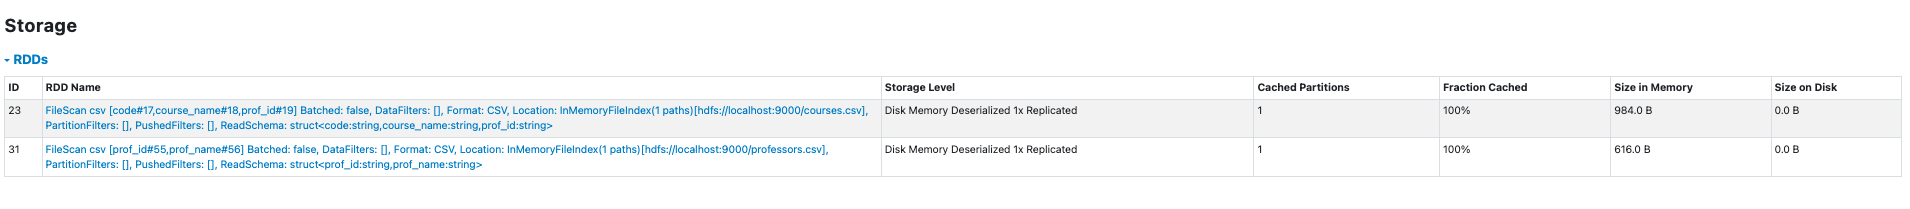

In [7]:
courses.show() ##Job id 2

+------+--------------------+-------+
|  code|         course_name|prof_id|
+------+--------------------+-------+
|DSE230|Scalabale Data An...|      1|
|DSC102|Systems for Scala...|      1|
|DSC232|Big Data Analytic...|      1|
|DSE220|    Machine Learning|      2|
|CSE291|Unsupervised Lear...|      2|
|CSE253|       Deep Learning|      3|
+------+--------------------+-------+



In [8]:
professors.show() ##Job id 3

+-------+--------------------+
|prof_id|           prof_name|
+-------+--------------------+
|      1|    Prof. Mai Nguyen|
|      2|Prof. Sanjoy Dasg...|
|      4| Prof. Gary Cottrell|
+-------+--------------------+



###  Executors Tab - The Executors tab displays information about the executors used in the application, including their resource usage and task execution times.

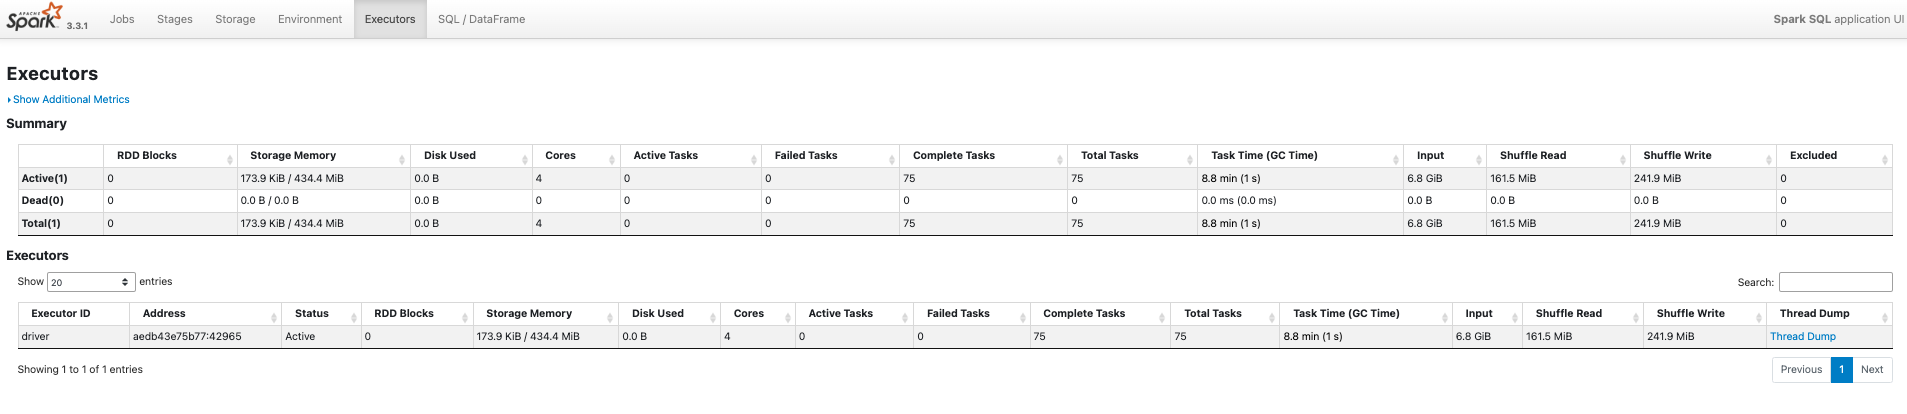

### SQL TAB - The SQL tab displays information about Spark SQL queries executed by the application, including their duration and resource usage.

In [9]:
courses.join(professors,"prof_id",how="inner").select("code","course_name","prof_id","prof_name").explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [code#17, course_name#18, prof_id#19, prof_name#56]
   +- BroadcastHashJoin [prof_id#19], [prof_id#55], Inner, BuildRight, false
      :- Filter isnotnull(prof_id#19)
      :  +- InMemoryTableScan [code#17, course_name#18, prof_id#19], [isnotnull(prof_id#19)]
      :        +- InMemoryRelation [code#17, course_name#18, prof_id#19], StorageLevel(disk, memory, deserialized, 1 replicas)
      :              +- FileScan csv [code#17,course_name#18,prof_id#19] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[hdfs://localhost:9000/courses.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<code:string,course_name:string,prof_id:string>
      +- BroadcastExchange HashedRelationBroadcastMode(List(input[0, string, false]),false), [plan_id=82]
         +- Filter isnotnull(prof_id#55)
            +- InMemoryTableScan [prof_id#55, prof_name#56], [isnotnull(prof_id#55)]
               

In [10]:
courses.join(professors,"prof_id",how="inner").select("code","course_name","prof_id","prof_name").show()  ##Job id 5

+------+--------------------+-------+--------------------+
|  code|         course_name|prof_id|           prof_name|
+------+--------------------+-------+--------------------+
|DSE230|Scalabale Data An...|      1|    Prof. Mai Nguyen|
|DSC102|Systems for Scala...|      1|    Prof. Mai Nguyen|
|DSC232|Big Data Analytic...|      1|    Prof. Mai Nguyen|
|DSE220|    Machine Learning|      2|Prof. Sanjoy Dasg...|
|CSE291|Unsupervised Lear...|      2|Prof. Sanjoy Dasg...|
+------+--------------------+-------+--------------------+



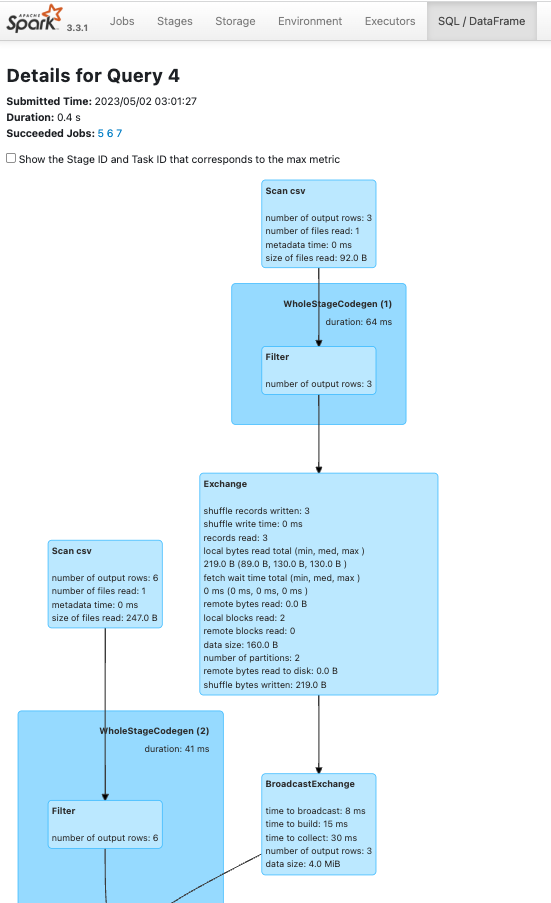

### Job vs Stage Vs Task

**Job**: A Job is a high-level unit of work in Apache Spark that represents a single batch computation consisting of multiple stages. A Job is typically submitted to the SparkContext by a user program, and it consists of multiple stages that are executed sequentially. A Job can be thought of roughly as one spark action although you may find extra jobs created by Spark's optimization engine.

**Stage**: A Stage is an intermediate step in a Spark Job that represents a set of tasks that can be executed in parallel. A Stage is typically created by the Spark runtime system during the optimization process, where it groups together tasks that can be executed together on the same set of data. A Stage is defined by the set of transformations and actions that need to be executed, and it represents a point in the computation where data is shuffled between nodes.

**Task**: A Task is the smallest unit of work in Apache Spark that represents a single unit of computation that can be executed on a single partition of data. A Task is typically created by the Spark runtime system during the execution phase, where it represents a single unit of work that can be executed by a single worker node. Each Task is executed on a single partition of data and is allocated to 1 core for processing.

To summarize, a Job is a high-level unit of work that consists of multiple stages, each of which represents a set of tasks that can be executed in parallel. A Stage is an intermediate step in a Job that groups together tasks that can be executed together on the same set of data. A Task is the smallest unit of work that represents a single unit of computation that can be executed on a single partition of data.

#### READING, FILTERING AND COUNTING

In [12]:
df = spark.read.load('file:///home/work/PA3_DSE230/Airline_2016_2018.csv', format="csv", header="true") \
                .select('OP_CARRIER_FL_NUM','OP_CARRIER', 'ORIGIN', 'DEST', 'AIR_TIME')   #job Id 6

In [13]:
df.show(10)   ## Job Id 7
print('Number of partitions=',df.rdd.getNumPartitions()) ## Partitions = (File Size / partiton max size(128MB by default))=(2.43GB*1024)/128 = 19

+-----------------+----------+------+----+--------+
|OP_CARRIER_FL_NUM|OP_CARRIER|ORIGIN|DEST|AIR_TIME|
+-----------------+----------+------+----+--------+
|             1248|        DL|   DTW| LAX|   249.0|
|             1251|        DL|   ATL| GRR|    92.0|
|             1254|        DL|   LAX| ATL|   207.0|
|             1255|        DL|   SLC| ATL|   173.0|
|             1256|        DL|   BZN| MSP|   121.0|
|             1257|        DL|   ATL| BNA|    38.0|
|             1257|        DL|   BNA| ATL|    37.0|
|             1258|        DL|   ATL| JAX|    45.0|
|             1258|        DL|   JAX| ATL|    43.0|
|             1259|        DL|   ATL| OKC|   116.0|
+-----------------+----------+------+----+--------+
only showing top 10 rows

Number of partitions= 19


In [14]:
df = df.filter(df.OP_CARRIER_FL_NUM<1255)
df.count()    ## Job Id 8

6625577

#### WINDOW PARTITION PROCESSING

In [15]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.functions import rank,dense_rank
from pyspark.sql.functions import avg,col

windowPartitionAvg = Window.partitionBy("OP_CARRIER_FL_NUM")
df.withColumn("Avg Flight Time Per Carrier",avg(col("AIR_TIME")).over(windowPartitionAvg)).show() ##Job id 10

+-----------------+----------+------+----+--------+---------------------------+
|OP_CARRIER_FL_NUM|OP_CARRIER|ORIGIN|DEST|AIR_TIME|Avg Flight Time Per Carrier|
+-----------------+----------+------+----+--------+---------------------------+
|              100|        B6|   LAX| FLL|   253.0|         152.82824834649028|
|              100|        B6|   LAX| FLL|   277.0|         152.82824834649028|
|              100|        B6|   LAX| FLL|   246.0|         152.82824834649028|
|              100|        B6|   LAX| FLL|   275.0|         152.82824834649028|
|              100|        B6|   LAX| FLL|   264.0|         152.82824834649028|
|              100|        WN|   LAS| MDW|   174.0|         152.82824834649028|
|              100|        B6|   LAX| FLL|   253.0|         152.82824834649028|
|              100|        AS|   ANC| SEA|   180.0|         152.82824834649028|
|              100|        WN|   BWI| MCO|   114.0|         152.82824834649028|
|              100|        B6|   LAX| FL

### WRITING TO PARQUET

In [16]:
df.repartition(4).write.parquet('/filtered_df', mode="overwrite") ##Job id 12

In [17]:
!hadoop fs -ls lrt /filtered_df

2023-05-20 17:08:11,709 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
ls: `lrt': No such file or directory
Found 5 items
-rw-r--r--   1 root supergroup          0 2023-05-20 17:08 /filtered_df/_SUCCESS
-rw-r--r--   1 root supergroup    8573985 2023-05-20 17:08 /filtered_df/part-00000-192fb1cf-84c9-4d74-a24b-f3241a57cad0-c000.snappy.parquet
-rw-r--r--   1 root supergroup    8574011 2023-05-20 17:08 /filtered_df/part-00001-192fb1cf-84c9-4d74-a24b-f3241a57cad0-c000.snappy.parquet
-rw-r--r--   1 root supergroup    8573997 2023-05-20 17:08 /filtered_df/part-00002-192fb1cf-84c9-4d74-a24b-f3241a57cad0-c000.snappy.parquet
-rw-r--r--   1 root supergroup    8574195 2023-05-20 17:08 /filtered_df/part-00003-192fb1cf-84c9-4d74-a24b-f3241a57cad0-c000.snappy.parquet


### Jobs Tab - The Jobs tab displays information about the individual jobs in the application, including their status, duration, and resource usage.

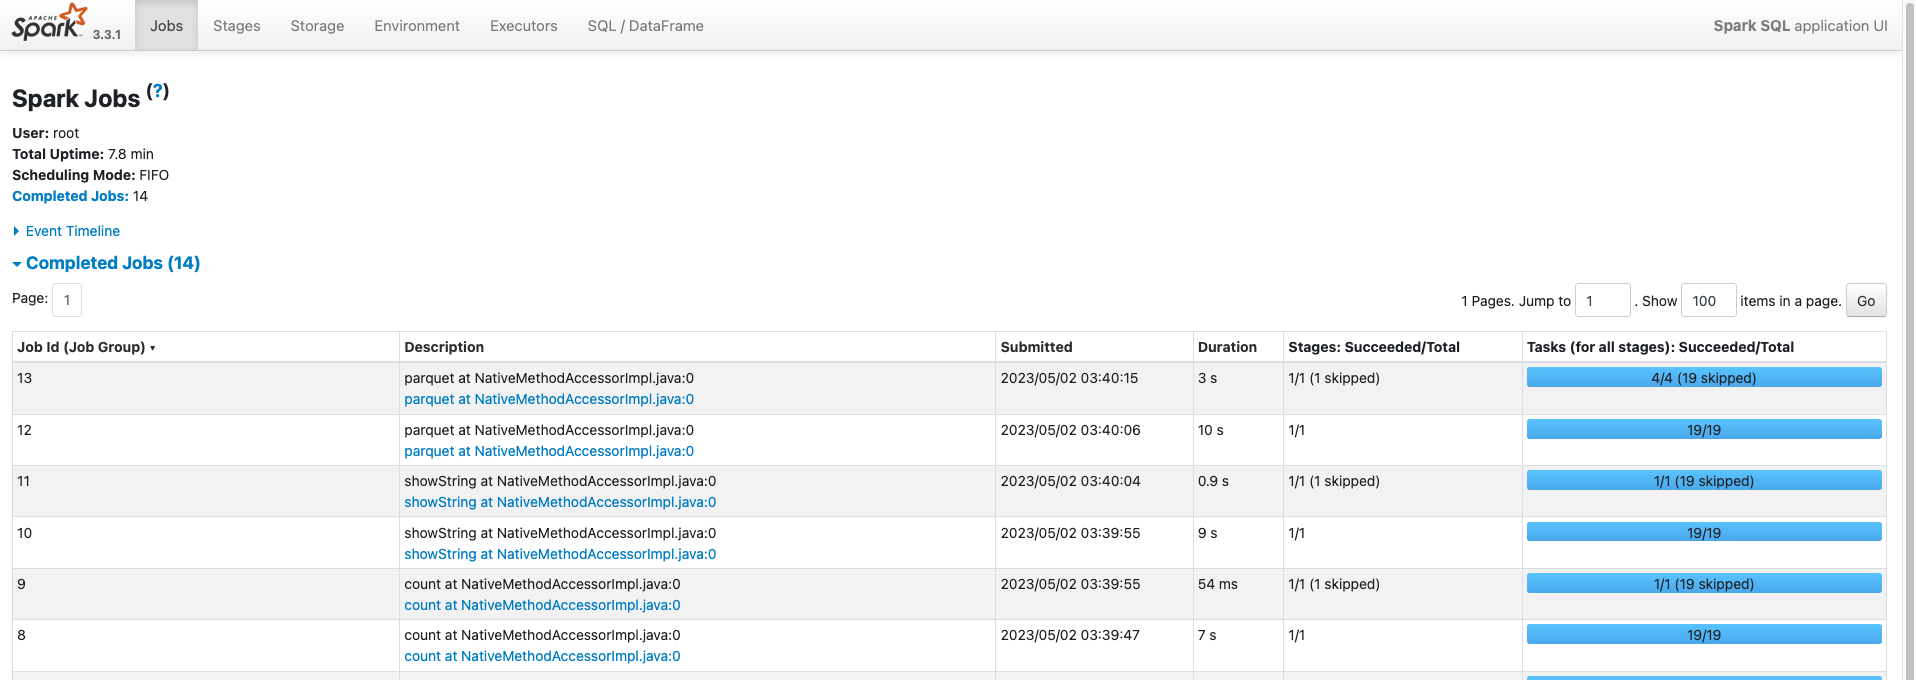

#### STAGES TAB - The Stages tab provides a breakdown of each job into its individual stages, showing their status, duration, and resource usage.

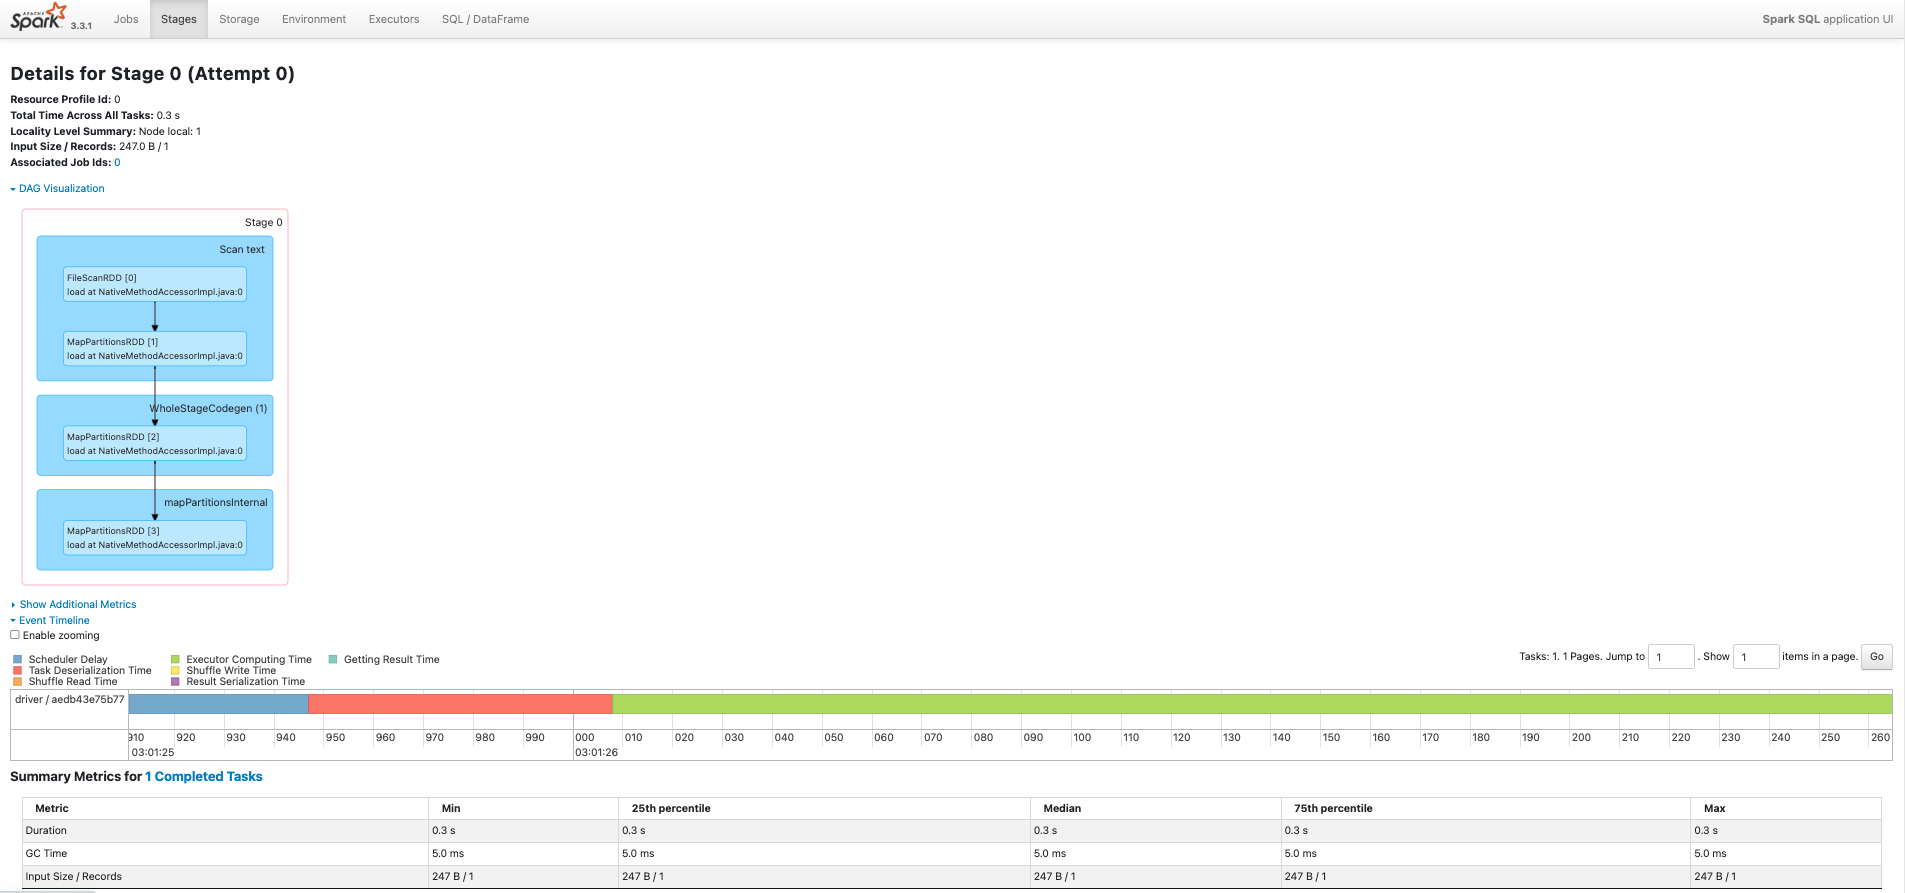

#### Note
In Apache Spark, a skipped job or stage in the Spark UI indicates that the Spark runtime system has determined that the job or stage is not necessary for the computation.

When a job or stage is submitted to the Spark runtime system, it goes through an optimization process that determines the most efficient way to execute the computation. During this optimization process, the Spark runtime system may determine that some jobs or stages can be skipped because their output is not required or because they can be combined with other jobs or stages.

If a job or stage is skipped, it will not be executed by the Spark runtime system, and its status in the Spark UI will be marked as "Skipped". The resources that would have been used to execute the skipped job or stage are then allocated to other jobs or stages, which can improve the overall performance of the Spark application.